# Spanish Translation A/B Test
This exercise analyzes hypothetical A/B test data for an e-commerce website. The test notes that users based in Spain has a much higher conversion rate than other Spanish speaking countries. Test offers a potential reason for this: all Spanish translations are done by a Spainard, which in Spain is a local translation and that is responsible for the higher conversion rate. 

However, the A/B test data comes back negative, that non-localized translation does better. This exercise therefore does the following:

* Confirm that the test is actually negative. That is that non-local Spanish translation does better than local Spanish translation.

* Explain why this might be happening. Are localized translations really worse?


## Import necessary functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy import stats
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline

## Import data

In [2]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

Take a look at the data. 

In [3]:
test_table.head(10)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0
7,527287,2015-12-03,Direct,Web,EN,NaN,Chrome,0,0
8,261625,2015-12-04,Direct,Mobile,ES,NaN,Android_App,0,1
9,10427,2015-12-04,Ads,Mobile,ES,Facebook,Android_App,0,0


In [4]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


Check some basic assumptions about the test_table.

In [5]:
print 'CONTROL CONV RATE: ', test_table[test_table['test']==0]['conversion'].mean()
print 'TEST CONV RATE: ', test_table[test_table['test']==1]['conversion'].mean()

CONTROL CONV RATE:  0.0551786903067
TEST CONV RATE:  0.0434247139821


So it does look like control (written by Spanish translator) had higher conversion rate! Take a look deeper into the data to see if we can find other interesting things about the dataset.

In [6]:
len(pd.unique(user_table['user_id']))

452867

First, let's join test and user tables via **user_id**.

In [7]:
total_table = test_table.join(user_table.set_index('user_id'), on='user_id')
print total_table.head(10)
print len(total_table)

   user_id        date  source  device browser_language ads_channel  \
0   315281  2015-12-03  Direct     Web               ES         NaN   
1   497851  2015-12-04     Ads     Web               ES      Google   
2   848402  2015-12-04     Ads     Web               ES    Facebook   
3   290051  2015-12-03     Ads  Mobile            Other    Facebook   
4   548435  2015-11-30     Ads     Web               ES      Google   
5   540675  2015-12-03  Direct  Mobile               ES         NaN   
6   863394  2015-12-04     SEO  Mobile            Other         NaN   
7   527287  2015-12-03  Direct     Web               EN         NaN   
8   261625  2015-12-04  Direct  Mobile               ES         NaN   
9    10427  2015-12-04     Ads  Mobile               ES    Facebook   

       browser  conversion  test sex   age    country  
0           IE           1     0   M  32.0      Spain  
1           IE           0     1   M  21.0     Mexico  
2       Chrome           0     0   M  34.0      Sp

Ok, now take a look at some of the different features and how they affect the conversion rate.

In [8]:
total_table.describe(include=[np.number])

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [9]:
total_table.describe(include=[np.object])

,date,source,device,browser_language,ads_channel,browser,sex,country
count,453321,453321,453321,453321,181877,453321,452867,452867
unique,5,3,2,3,5,7,2,17
top,2015-12-04,Ads,Web,ES,Facebook,Android_App,M,Mexico
freq,141163,181877,251565,377547,68425,155135,264485,128484


In [10]:
total_table.count()

user_id             453321
date                453321
source              453321
device              453321
browser_language    453321
ads_channel         181877
browser             453321
conversion          453321
test                453321
sex                 452867
age                 452867
country             452867
dtype: int64

Check the results, if Spain does convert more than other countries.

In [11]:
total_table.groupby('country')['conversion'].mean().sort_values(ascending=False)

country
Spain          0.079719
Costa Rica     0.053494
Nicaragua      0.053399
Colombia       0.051332
El Salvador    0.050765
Mexico         0.050341
Peru           0.050258
Chile          0.049704
Venezuela      0.049666
Guatemala      0.049653
Honduras       0.049253
Ecuador        0.049072
Paraguay       0.048863
Bolivia        0.048634
Panama         0.048089
Argentina      0.013994
Uruguay        0.012821
Name: conversion, dtype: float64

Spain does convert at a much higer rate (almost 50% higher than country with 2nd highest conversion rate, Costa Rica)!

There likely is some implicit bias in how the samples were chosen. Let's do a t-test to see what the average conversion rate is for test and control samples without Spain as the country. If there is statistically significant difference between the two, then we can investigate the test samples further. 

In [12]:
test_data = total_table[total_table['country']!='Spain']
len(test_data)

401539

In [13]:
control = test_data[test_data['test']==0]
test = test_data[test_data['test']==1]
stats.ttest_ind(control['conversion'],test['conversion'])

Ttest_indResult(statistic=7.4225120959547688, pvalue=1.15144687852198e-13)

Ok, so a p-value of 1.15e-13 is very very small! Which means the difference we see in the average conversion rate between control and test sets are statistically significant. In fact, the chance of such difference coming about from random chance is 1.15e-11 percent!!

In [14]:
print 'TEST DATA AVG CONVERSION RATE: ', test['conversion'].mean()
print 'CONTROL DATA AVG CONVERSION RATE: ', control['conversion'].mean()
print 'DIFFERENCE: ', abs(test['conversion'].mean() - control['conversion'].mean())

TEST DATA AVG CONVERSION RATE:  0.0434247139821
CONTROL DATA AVG CONVERSION RATE:  0.0483304231607
DIFFERENCE:  0.00490570917854


Looking at the mean values, the difference is almost 10%! The likely reason for this drop in the test data average conversion rate would be:

1. We are not collecting enough data: This seems unlikely, as there are almost half million observations!

2. There is some unknown bias introduced into the sampling of test and control sets: This is the more likely scenario. 

Assuming #2 is the likely cause behind this difference, let's investigate what composes the test and control sets. 

Because the data set also includes time, let's look at that first to see if there's any noticeable difference in conversion rate and time accessed.

In [15]:
control_conv_vs_dates = np.asarray(control.groupby('date')['conversion'].mean())
test_conv_vs_dates = np.asarray(test.groupby('date')['conversion'].mean())

# this gives the conversion rate of test set/control set. to be plotted as a function of time (dates)
conv_vs_dates = test_conv_vs_dates/control_conv_vs_dates
dates = np.sort(control['date'].unique())

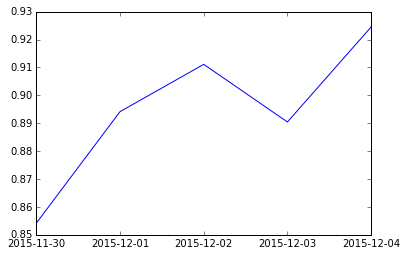

In [16]:
x = range(len(dates))
plt.plot(x,conv_vs_dates)
pylab.xticks(x,dates)
pylab.show()

Looking at this plot, the test set has consistently been worse at conversion than the control set. Also, while it may look like later dates have the test set performing better, the differences are likely insignificant here.

On a small side note, we should run the test longer than 5 days to capture any variations within a week. Even better, we should do this for 2 weeks to get the full spectrum.

Let's take a look at some other important features of the control and test set and compare them. How are different countries represented in the control and test data set?

In [17]:
countries = np.sort(control['country'].unique())
control.groupby('country').count()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age
country,,,,,,,,,,,
Argentina,9356,9356,9356,9356,9356,3770,9356,9356,9356,9356,9356
Bolivia,5550,5550,5550,5550,5550,2279,5550,5550,5550,5550,5550
Chile,9853,9853,9853,9853,9853,3953,9853,9853,9853,9853,9853
Colombia,27088,27088,27088,27088,27088,10848,27088,27088,27088,27088,27088
Costa Rica,2660,2660,2660,2660,2660,1067,2660,2660,2660,2660,2660
Ecuador,8036,8036,8036,8036,8036,3218,8036,8036,8036,8036,8036
El Salvador,4108,4108,4108,4108,4108,1667,4108,4108,4108,4108,4108
Guatemala,7622,7622,7622,7622,7622,3051,7622,7622,7622,7622,7622
Honduras,4361,4361,4361,4361,4361,1780,4361,4361,4361,4361,4361


In [18]:
test.groupby('country').count()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age
country,,,,,,,,,,,
Argentina,37377,37377,37377,37377,37377,14985,37377,37377,37377,37377,37377
Bolivia,5574,5574,5574,5574,5574,2234,5574,5574,5574,5574,5574
Chile,9884,9884,9884,9884,9884,3984,9884,9884,9884,9884,9884
Colombia,26972,26972,26972,26972,26972,10622,26972,26972,26972,26972,26972
Costa Rica,2649,2649,2649,2649,2649,1061,2649,2649,2649,2649,2649
Ecuador,7859,7859,7859,7859,7859,3025,7859,7859,7859,7859,7859
El Salvador,4067,4067,4067,4067,4067,1588,4067,4067,4067,4067,4067
Guatemala,7503,7503,7503,7503,7503,3027,7503,7503,7503,7503,7503
Honduras,4207,4207,4207,4207,4207,1662,4207,4207,4207,4207,4207


Woah, we immediately realize that some countries are way overrepresented in control group and vice versa! For example, Argentina is seen 37377 times in test set, while only 9356 times in control set. And Uruguay is present 3719 times in test set while only 415 times in the control set. 

And seeing how Uruguay and Argentina have some of the lowest conversion rate among different countries, this surely would affect the datasets by introducing a bias. 

To properly quantify this, several different methods can be used. But for this exercise, we will use a **decision tree**. If the control and test data sets truly have been picked randomly, then the resulting tree would be a very bad tree (since all features should be roughly 50/50 present in both datasets). But we know already that there's some imbalance in the data, and the tree should find out which features are not properly randomized. 

In [19]:
control

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico
9,10427,2015-12-04,Ads,Mobile,ES,Facebook,Android_App,0,0,F,33.0,Mexico
10,8343,2015-11-30,Ads,Mobile,ES,Bing,Android_App,1,0,M,37.0,Colombia
13,234023,2015-12-03,SEO,Web,ES,NaN,Chrome,0,0,F,19.0,El Salvador
14,207018,2015-12-03,Ads,Web,ES,Google,Chrome,0,0,F,28.0,Mexico
15,103879,2015-11-30,Direct,Mobile,ES,NaN,Iphone_App,0,0,M,27.0,Nicaragua
18,464816,2015-12-01,Direct,Web,ES,NaN,FireFox,0,0,F,28.0,Mexico
22,913301,2015-11-30,Direct,Mobile,ES,NaN,Iphone_App,0,0,F,45.0,Peru
23,833933,2015-11-30,SEO,Web,ES,NaN,FireFox,0,0,M,24.0,Mexico
24,601150,2015-12-03,Ads,Web,ES,Google,Chrome,0,0,M,23.0,Mexico


In [20]:
# drop all NaN values from test data (decision tree classifier only works with numeric values)
test_data = test_data.dropna()
# for X, pick all features except conversion (not important here)
X = test_data[['date','source','device','browser_language','browser','sex','age','country']]
# for y, we want whether or not an observation is a test or a control
Y = test_data['test']
# now we do some preprocessing with sklearn's preprocessing package to convert categorical data to numerical. 
# pandas already has a function that does this for you, get_dummies().
columns_to_preproc = ['date','source','device','browser_language','browser','sex','country']
X = pd.get_dummies(X,columns_to_preproc)

In [21]:
# now create the decision tree model
# we choose the max_depth to be 2 to see what features the tree splits on from the root node. For minimum batch size,
# we pick 1% of the entire test dataset 
ct = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=len(test_data)/100)
ct.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1608,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [22]:
print X.columns[ct.tree_.feature]
print ct.tree_.threshold

Index([u'country_Argentina', u'country_Uruguay', u'country_Uruguay',
       u'country_Uruguay', u'device_Web', u'country_Uruguay',
       u'country_Uruguay'],
      dtype='object')
[ 0.5  0.5 -2.  -2.   0.5 -2.  -2. ]


It looks like our suspicions were correct. The decision tree classifier split the control and test data predominantly on countries of Argentina and Uruguay. Also, the tree split on Mobile device, although from counting the occurences of Mobile/Web for control and test set, we know this difference is small.

Let's plot occurences of each country for control and test data set in matplotlib to further drive the point home.

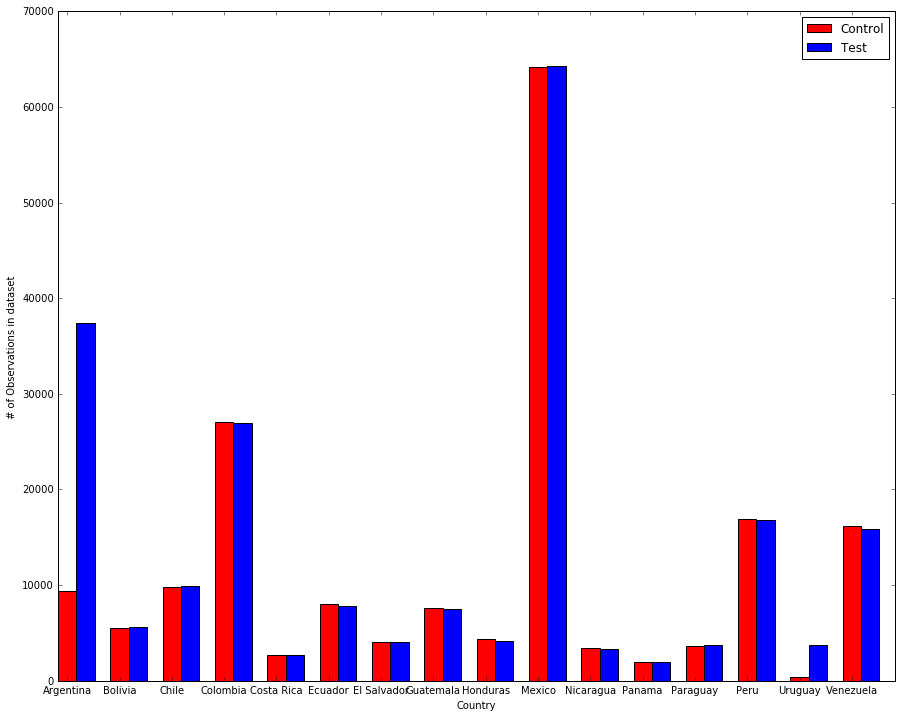

In [23]:
countries = sorted(test_data['country'].unique())
control_counts = control.groupby('country').count()
control_counts = control_counts['user_id']
test_counts = test.groupby('country').count()
test_counts = test_counts['user_id']

ind = np.arange(len(countries))
width = 0.35

fig, ax = plt.subplots(figsize=(15,12))
control_bars = ax.bar(ind, control_counts, width, color='r')
test_bars = ax.bar(ind+width, test_counts, width, color='b')

ax.set_xlabel('Country')
ax.set_ylabel('# of Observations in dataset')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(countries)
ax.legend((control_bars[0], test_bars[0]),('Control','Test'))

plt.show()

We can clearly see the discrepancy between test and control set for countries **Argentina** and **Uruguay**!

Finally, to see if the null hypothesis is true (that local translators don't have an effect on conversion rate), let's check for conversion rate after controlling for country. We can do this by simply checking conversion rates for control and test data for each country separately.

In [24]:
control_conv_country = control.groupby('country')['conversion'].mean()
test_conv_country = test.groupby('country')['conversion'].mean()

# perform t-test for each group of dataset with same country
p_vals = []
for country in countries:
    p_val = stats.ttest_ind(control[control['country']==country]['conversion'],
                            test[test['country']==country]['conversion'])[1]
    p_vals.append(p_val)
    
conv_country = pd.concat([control_conv_country, test_conv_country], axis=1)
conv_country.columns = ['control_conversion','test_conversion']
conv_country['p_value'] = p_vals
conv_country

,control_conversion,test_conversion,p_value
country,,,
Argentina,0.015071,0.013725,0.321766
Bolivia,0.049369,0.047901,0.718877
Chile,0.048107,0.051295,0.302871
Colombia,0.052089,0.050571,0.423733
Costa Rica,0.052256,0.054738,0.687863
Ecuador,0.049154,0.048988,0.961512
El Salvador,0.053554,0.047947,0.248251
Guatemala,0.050643,0.048647,0.572165
Honduras,0.050906,0.047540,0.471721


Indeed, when we control for the country and check the conversion rates, they are both pretty close to 50/50 for all countries. The corresponding P-values also show that the null hypothesis is likely valid. 

To finish this exercise, we can conclude the following:

1. The test is not negative, and the null hypothesis is true. This means that the translation, whether it's old or new (meaning local), does NOT have a statistically significant effect on the conversion rate.

2. The test was not statistically significant due to bias in the sampling of the control set and test set. Namely, 2 countries, Argentina and Uruguay, both of which has very low conversion rates, affected the mean conversion rates for control and test datasets.

*This exercise was completed on 7/25/2017. Time to completion: 4:39:00. Looked at the solutions to get an idea for the solution structure.* 

*Notes: Learned about t-test, and how check for biased sampling of control/test dataset using decision tree classifier. Dealt with unreliable data by simply deleting them from the dataset, which gave slightly different conversion rates and p-values than the solution.*